<a href="https://colab.research.google.com/github/The-cheater/Deep_Learning_Models/blob/main/cifar10%26Imagenet_MM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Input, Model

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Convert RGB to grayscale
x_train_gray = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]
x_test_gray  = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]

# Data pipeline (no resizing, minimal augmentation to prevent system crashes)
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices(((x_train, x_train_gray), y_train))
train_ds = train_ds.shuffle(50000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(((x_test, x_test_gray), y_test))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# CNN model
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    return x

input_rgb = Input(shape=(32, 32, 3), name='rgb_input')
input_gray = Input(shape=(32, 32, 1), name='gray_input')

# RGB stream
x1 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_rgb)
x1 = conv_block(x1, 64)
x1 = conv_block(x1, 128)
x1 = conv_block(x1, 128)

# Grayscale stream
x2 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_gray)
x2 = conv_block(x2, 64)
x2 = conv_block(x2, 128)
x2 = conv_block(x2, 128)

# Concatenation and further layers
x = layers.Concatenate(axis=-1)([x1, x2])
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)

model = Model(inputs=[input_rgb, input_gray], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_input          │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ rgb_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │        320 │ gray_input[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ max_pooling2d_1[

 Total params: 1,734,218 (6.62 MB)

 Trainable params: 1,731,914 (6.61 MB)

 Non-trainable params: 2,304 (9.00 KB)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.4934 - loss: 1.4278 - val_accuracy: 0.6740 - val_loss: 0.9053
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.7503 - loss: 0.7110 - val_accuracy: 0.7153 - val_loss: 0.8191
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8310 - loss: 0.4933 - val_accuracy: 0.7740 - val_loss: 0.6619
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8752 - loss: 0.3611 - val_accuracy: 0.7414 - val_loss: 0.7920
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9133 - loss: 0.2551 - val_accuracy: 0.7854 - val_loss: 0.7223
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9364 - loss: 0.1798 - val_accuracy: 0.7782 - val_loss: 0.8186
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9538 - loss: 0.1305 - val_accuracy: 0.7543 - val_loss: 0.9695
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9634 - loss: 0.1043 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7747 - loss: 0.6569
Test accuracy: 0.7740
Test loss: 0.6619


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


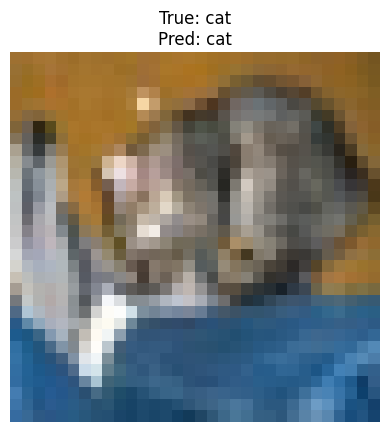

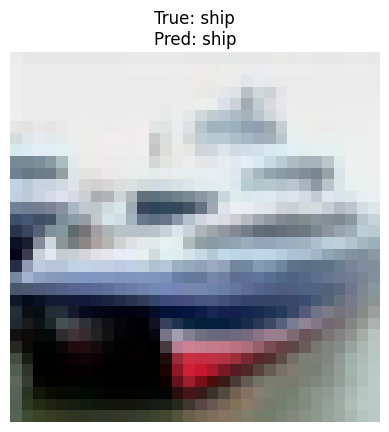

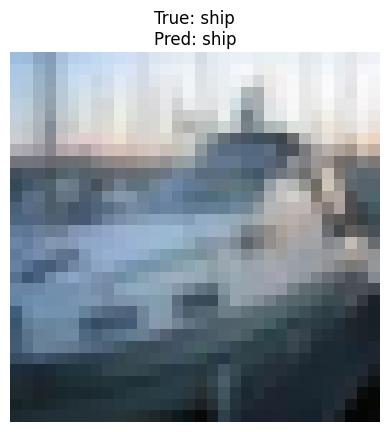

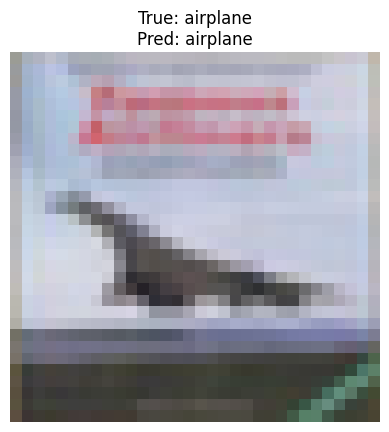

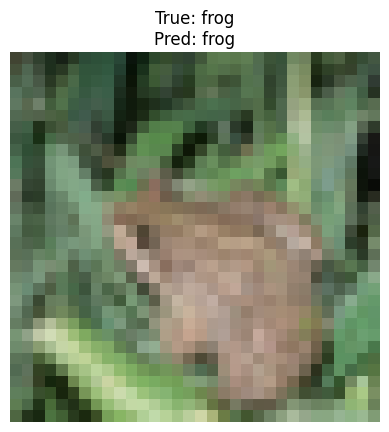

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a small batch from the test set
for (x_rgb, x_gray), y_true in test_ds.take(1):
    y_pred = model.predict((x_rgb, x_gray))
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot the first 5 images
    for i in range(5):
        plt.imshow(x_rgb[i].numpy())
        plt.title(f"True: {class_names[y_true[i][0]]}\nPred: {class_names[y_pred_labels[i]]}")
        plt.axis('off')
        plt.show()


In [ ]:
idx = 0  # Pick an index from test set
sample_rgb = x_test[idx:idx+1]  # Shape (1, 32, 32, 3)
sample_gray = x_test_gray[idx:idx+1]  # Shape (1, 32, 32, 1)

prediction = model.predict((sample_rgb, sample_gray))
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: cat


In [ ]:
# IMAGENET MM MODEL TESTING

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gray_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 224, 224,  │      1,792 │ rgb_input[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 224, 224,  │        640 │ gray_input[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 224, 224,  │     73,856 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 224, 224,  │     73,856 │ conv2d_18[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        512 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 112, 112,  │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 112, 112,  │    295,168 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 56, 56,    │    590,080 │ max_pooling2d_12

 Total params: 29,117,066 (111.07 MB)

 Trainable params: 29,110,410 (111.05 MB)

 Non-trainable params: 6,656 (26.00 KB)

Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - accuracy: 0.2983 - loss: 2.5641 - val_accuracy: 0.1200 - val_loss: 3.5360
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 290s 912ms/step - accuracy: 0.5909 - loss: 1.2347 - val_accuracy: 0.2418 - val_loss: 4.7984
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 310s 871ms/step - accuracy: 0.6971 - loss: 0.9397 - val_accuracy: 0.5939 - val_loss: 1.4131
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 273s 910ms/step - accuracy: 0.7529 - loss: 0.7607 - val_accuracy: 0.4311 - val_loss: 2.5414
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 271s 910ms/step - accuracy: 0.7928 - loss: 0.6468 - val_accuracy: 0.5885 - val_loss: 1.5055
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 260s 870ms/step - accuracy: 0.8280 - loss: 0.5472 - val_accuracy: 0.6385 - val_loss: 1.2878
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 272s 910ms/step - accuracy: 0.8436 - loss: 0.4736 - val_accuracy: 0.7062 - val_loss: 1.1363
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 308s 869ms/step - accuracy: 0.8797 - lo

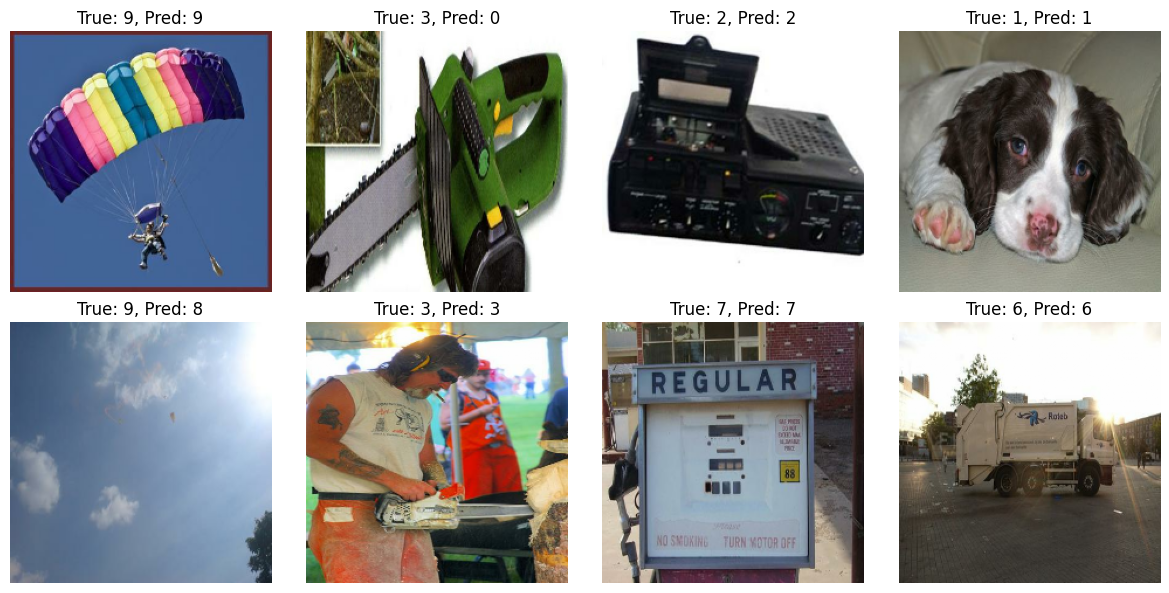

In [2]:
# Install and import necessary libraries
!pip install tensorflow tensorflow-datasets --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Input, Model
import numpy as np

# 1. Load a subset of ImageNet (imagenette) from TFDS
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(example):
    img = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE))
    img_rgb = tf.cast(img, tf.float32) / 255.0
    img_gray = tf.image.rgb_to_grayscale(img_rgb)
    label = example['label']
    return (img_rgb, img_gray), label

# Download and prepare the data
train_ds = tfds.load('imagenette/320px-v2', split='train', as_supervised=False)
val_ds = tfds.load('imagenette/320px-v2', split='validation', as_supervised=False)

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# 2. Define the MMCNN architecture (last pooling removed to avoid negative dimension error)

def conv_block(x, filters, pool=True):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    if pool:
        x = layers.MaxPooling2D()(x)
    return x

input_rgb = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='rgb_input')
input_gray = Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='gray_input')

# RGB stream
x1 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_rgb)
x1 = conv_block(x1, 128)
x1 = conv_block(x1, 256)
x1 = conv_block(x1, 256, pool=False)
x1 = layers.MaxPooling2D()(x1)
x1 = conv_block(x1, 256, pool=False)

# Grayscale stream
x2 = layers.Conv2D(64, 3, padding='same', activation='relu')(input_gray)
x2 = conv_block(x2, 128)
x2 = conv_block(x2, 256)
x2 = conv_block(x2, 256, pool=False)
x2 = layers.MaxPooling2D()(x2)
x2 = conv_block(x2, 256, pool=False)

# Concatenate
x = layers.Concatenate(axis=-1)([x1, x2])

# Deeper layers (last pooling removed)
x = conv_block(x, 512)
x = conv_block(x, 512)
x = layers.MaxPooling2D()(x)
x = conv_block(x, 512)
# Remove the next pooling to avoid negative dimension error
# x = layers.MaxPooling2D()(x)

# Flatten and Dense layers
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(4096, activation='relu')(x)
output = layers.Dense(10, activation='softmax')(x)  # imagenette has 10 classes

model = Model(inputs=[input_rgb, input_gray], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# 3. Train the model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

# 4. Test the model
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# 5. Visualize predictions on a batch
import matplotlib.pyplot as plt

for (rgb_imgs, gray_imgs), labels in val_ds.take(1):
    preds = model.predict([rgb_imgs, gray_imgs])
    pred_labels = np.argmax(preds, axis=1)
    true_labels = labels.numpy()

    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(rgb_imgs[i].numpy())
        plt.title(f"True: {true_labels[i]}, Pred: {pred_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break
